In [3]:
import os
import numpy as np
import time 
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import patches as mpatches  # Import mpatches here
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [4]:
data_path = '/kaggle/input/cs604-project/'

# List the contents of the data directory
print(os.listdir(data_path))

['train_images', 'train_masks']


In [5]:
import math

total_images = 1631

# Calculate the number of images for each set
train_size = int(0.90 * total_images)
val_size = int(0.10 * total_images)
# test_size = total_images - train_size - val_size  # Adjust for any rounding errors

print(f"Training images: {train_size}")
print(f"Validation images: {val_size}")
# print(f"Test images: {test_size}")

Training images: 1467
Validation images: 163


In [6]:
image_dir = '/kaggle/input/cs604-project/train_images/'
mask_dir = '/kaggle/input/cs604-project/train_masks/'

# image_dir = f'{data_path}/train_images/'
# mask_dir = f'{data_path}/train_masks/'

all_filenames = sorted(os.listdir(image_dir))

In [7]:
from sklearn.model_selection import train_test_split

# First split into training and temp (validation)
train_filenames, val_filenames = train_test_split(all_filenames,test_size=(val_size),random_state=42)

# Now split temp into validation and test
# val_filenames, test_filenames = train_test_split(temp_filenames,test_size=test_size,random_state=42)

print(f"Total images: {len(all_filenames)}")
print(f"Training images: {len(train_filenames)}")
print(f"Validation images: {len(val_filenames)}")
# print(f"Test images: {len(test_filenames)}")


Total images: 1631
Training images: 1468
Validation images: 163


In [8]:
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = os.listdir(image_dir)
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name  # Since filenames match
        mask_path = os.path.join(self.mask_dir, mask_name)

        # Load image and mask
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # 'L' mode for grayscale

        # Apply transformations
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask


In [9]:
from torchvision import transforms

transform_image = transforms.Compose([
   transforms.Resize((224, 224)),
   transforms.ToTensor(),
   transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
   # transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.05),  # Adding Gaussian noise
   # Normalize using ImageNet mean and std if desired
   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.PILToTensor(),  # Converts to tensor without normalization
    transforms.Lambda(lambda x: x.squeeze().long())  # Remove channel dimension and convert to long
])


In [10]:
# Training dataset and loader
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=transform_image,
    transform_mask=transform_mask
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

# Validation dataset and loader
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=transform_image,
    transform_mask=transform_mask
)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

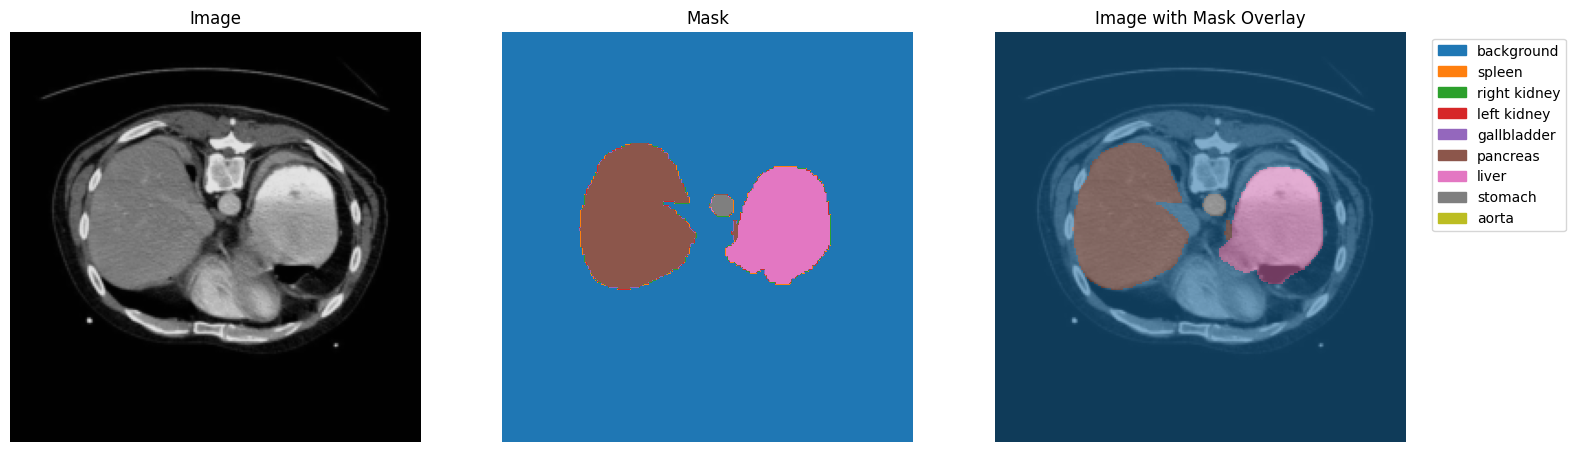

In [11]:
def visualize_sample(dataset, idx=None, filename=None):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import colors as mcolors
    from PIL import Image

    # Load image and mask
    if idx is not None:
        image, mask = dataset[idx]
        img_name = dataset.image_filenames[idx]
    elif filename is not None:
        idx = dataset.image_filenames.index(filename)
        image, mask = dataset[idx]
        img_name = filename
    else:
        raise ValueError("Either idx or filename must be provided.")

    # Prepare image for visualization
    image_np = image.permute(1, 2, 0).numpy()
    image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)

    mask_np = mask.numpy()

    # Define class names and colors
    class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder', 'pancreas', 'liver', 'stomach', 'aorta']
    colors = plt.cm.tab10.colors
    colormap = mcolors.ListedColormap(colors[:9])

    # Create color mask
    mask_rgba = colormap(mask_np / 8.0)
    mask_rgba[..., 3] = 0.5  # Set alpha for transparency

    # Plot image and mask
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    ax1.imshow(image_np)
    ax1.set_title('Image')
    ax1.axis('off')

    ax2.imshow(mask_np, cmap=colormap, vmin=0, vmax=8)
    ax2.set_title('Mask')
    ax2.axis('off')

    ax3.imshow(image_np)
    ax3.imshow(mask_rgba, interpolation='none')
    ax3.set_title('Image with Mask Overlay')
    ax3.axis('off')

    # Create legend
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

visualize_sample(train_dataset, idx=1)


In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout)
        )

    def forward(self, x):
        return self.conv(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mode='transpose'):
        super(UpBlock, self).__init__()
        if mode == 'transpose':
            self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        elif mode == 'bilinear':
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1)
            )
        else:
            raise ValueError("Invalid mode for upsampling. Choose 'transpose' or 'bilinear'.")

    def forward(self, x):
        return self.up(x)
    
class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=3, out_channels=9, dropout=0.5):
        super(UNetPlusPlus, self).__init__()
        
        # Load the pretrained ResNet34 model
        resnet = models.resnet34(pretrained=True)
        
        # Extract layers from ResNet to build the encoder
        self.encoder = nn.ModuleList([
            resnet.conv1,   # [64, H/2, W/2]
            resnet.bn1,
            resnet.relu,
            resnet.maxpool, # [64, H/4, W/4]
            resnet.layer1,  # [64, H/4, W/4]
            resnet.layer2,  # [128, H/8, W/8]
            resnet.layer3,  # [256, H/16, W/16]
            resnet.layer4   # [512, H/32, W/32]
        ])
        
        nb_filter = [64, 64, 128, 256, 512]
        
        # Decoder
        self.up3_1 = UpBlock(nb_filter[4], nb_filter[3])
        self.conv3_1 = ConvBlock(nb_filter[4], nb_filter[3], dropout=dropout)
        
        self.up2_2 = UpBlock(nb_filter[3], nb_filter[2])
        self.conv2_2 = ConvBlock(nb_filter[3], nb_filter[2], dropout=dropout)
        
        self.up1_3 = UpBlock(nb_filter[2], nb_filter[1])
        self.conv1_3 = ConvBlock(nb_filter[2], nb_filter[1], dropout=dropout)
        
        self.up0_4 = UpBlock(nb_filter[1], nb_filter[0])
        self.conv0_4 = ConvBlock(nb_filter[1] + nb_filter[0], nb_filter[0], dropout=dropout)
        
        # **Extra Upsampling Layer to Restore Original Spatial Dimensions**
        self.up_extra = UpBlock(nb_filter[0], nb_filter[0])
        self.conv_extra = ConvBlock(nb_filter[0] + in_channels, nb_filter[0], dropout=dropout)
        
        # Final Output Layer
        self.final = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        x0 = self.encoder[0](x)    # conv1
        x0 = self.encoder[1](x0)   # bn1
        x0 = self.encoder[2](x0)   # relu

        x0p = self.encoder[3](x0)  # maxpool

        x1 = self.encoder[4](x0p)  # layer1
        x2 = self.encoder[5](x1)   # layer2
        x3 = self.encoder[6](x2)   # layer3
        x4 = self.encoder[7](x3)   # layer4

        # Decoder
        x3_1 = self.up3_1(x4)
        x3_1 = torch.cat([x3_1, x3], dim=1)
        x3_1 = self.conv3_1(x3_1)

        x2_2 = self.up2_2(x3_1)
        x2_2 = torch.cat([x2_2, x2], dim=1)
        x2_2 = self.conv2_2(x2_2)

        x1_3 = self.up1_3(x2_2)
        x1_3 = torch.cat([x1_3, x1], dim=1)
        x1_3 = self.conv1_3(x1_3)

        x0_4 = self.up0_4(x1_3)
        x0_4 = torch.cat([x0_4, x0], dim=1)
        x0_4 = self.conv0_4(x0_4)

        # **Extra upsampling to match input size**
        x_extra = self.up_extra(x0_4)
        x_extra = torch.cat([x_extra, x], dim=1)  # Concatenate with original input
        x_extra = self.conv_extra(x_extra)

        output = self.final(x_extra)
        return output




In [13]:
import typing
from typing import List
from typing import Optional
from torch import Tensor
from torch.nn.modules.loss import _Loss


def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray) and x.dtype.kind not in {"O", "M", "U", "S"}:
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.ndarray(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x

    raise ValueError("Unsupported input type" + str(type(x)))


def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """

    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:

    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.

    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score


__all__ = ["DiceLoss"]

BINARY_MODE = "binary"
MULTICLASS_MODE = "multiclass"
MULTILABEL_MODE = "multilabel"


class DiceLoss(_Loss):
    """
    Implementation of Dice loss for image segmentation task.
    It supports binary, multiclass and multilabel cases
    """

    def __init__(
        self,
        mode: str,
        classes: List[int] = None,
        log_loss=False,
        from_logits=True,
        smooth: float = 0.0,
        ignore_index=None,
        eps=1e-7,
    ):
        """

        :param mode: Metric mode {'binary', 'multiclass', 'multilabel'}
        :param classes: Optional list of classes that contribute in loss computation;
        By default, all channels are included.
        :param log_loss: If True, loss computed as `-log(jaccard)`; otherwise `1 - jaccard`
        :param from_logits: If True assumes input is raw logits
        :param smooth:
        :param ignore_index: Label that indicates ignored pixels (does not contribute to loss)
        :param eps: Small epsilon for numerical stability
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.ignore_index = ignore_index
        self.log_loss = log_loss

    def forward(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
        """

        :param y_pred: NxCxHxW
        :param y_true: NxHxW
        :return: scalar
        """
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()

In [14]:
class weighted_loss(nn.Module):
    def __init__(self, reduction='mean', lamb=1.25):
        super().__init__()
        self.reduction = reduction
        self.lamb = lamb
        self.base_loss = torch.nn.CrossEntropyLoss(reduction=reduction)
        self.dice_loss = DiceLoss(mode='multiclass')
        
    def forward(self, logits, target):
        base_l = self.base_loss(logits, target)
        dice_l = self.dice_loss(logits, target)
        
        return base_l + self.lamb * dice_l

In [15]:
def compute_iou(preds, labels, num_classes):
    preds = preds.view(-1)
    labels = labels.view(-1)
    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)

    for cls in range(num_classes):
        pred_inds = (preds == cls)
        label_inds = (labels == cls)
        intersection[cls] = (pred_inds & label_inds).sum().item()
        union[cls] = (pred_inds | label_inds).sum().item()

    return intersection, union

def compute_miou(intersection, union):
    iou_per_class = intersection / (union + 1e-6)  # Avoid division by zero
    miou = np.nanmean(iou_per_class)
    return miou, iou_per_class

In [16]:
def train_model(model, criterion, optimizer, num_epochs=10, patience=5, save_path='model.pth'):
    import numpy as np

    # Access the first convolutional layer of the encoder
    conv_layer = model.encoder[0]  # This is resnet.conv1
    before_mean = conv_layer.weight.data.mean().item()
    print(f"Before Training Mean: {before_mean:.6f}")
    
    best_miou = 0.0
    patience_counter = 0
    num_classes = 9  # Number of classes
    class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder',
                   'pancreas', 'liver', 'stomach', 'aorta']

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        intersection = np.zeros(num_classes)
        union = np.zeros(num_classes)
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            # Compute predictions
            _, preds = torch.max(outputs, 1)
            
            # Compute intersection and union for each class
            for cls in range(num_classes):
                pred_inds = (preds == cls)
                label_inds = (labels == cls)
                intersection[cls] += torch.sum(pred_inds & label_inds).item()
                union[cls] += torch.sum(pred_inds | label_inds).item()
        
        epoch_loss = running_loss / len(train_dataset)
        train_miou, train_iou_per_class = compute_miou(intersection, union)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_intersection = np.zeros(num_classes)
        val_union = np.zeros(num_classes)
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item() * val_inputs.size(0)
                
                # Compute predictions
                _, val_preds = torch.max(val_outputs, 1)
                
                # Compute intersection and union for each class
                for cls in range(num_classes):
                    pred_inds = (val_preds == cls)
                    label_inds = (val_labels == cls)
                    val_intersection[cls] += torch.sum(pred_inds & label_inds).item()
                    val_union[cls] += torch.sum(pred_inds | label_inds).item()
        
        val_epoch_loss = val_running_loss / len(val_dataset)
        val_miou, val_iou_per_class = compute_miou(val_intersection, val_union)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}, Train mIoU: {train_miou:.4f}")
        for idx, iou in enumerate(train_iou_per_class):
            print(f" - Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}, Val mIoU: {val_miou:.4f}")
        for idx, iou in enumerate(val_iou_per_class):
            print(f" - Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        
        # Check for improvement
        if val_miou > best_miou:
            best_miou = val_miou
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path}.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break
        model.train()
    
    # Get the weights of the same convolutional layer after training
    after_mean = conv_layer.weight.data.mean().item()
    print(f"After Training Mean: {after_mean:.6f}")
    
    # Save the final model
    torch.save(model.state_dict(), save_path)


In [22]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize first model
set_seed(42)
model1 = UNetPlusPlus(in_channels=3, out_channels=9, dropout=0.3)
model1 = model1.to(device)

# Define the loss function and optimizer
criterion = weighted_loss(reduction='mean', lamb=1.25)
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)

# Train the model
train_model(model1, criterion, optimizer1, num_epochs=300, patience=5, save_path='UNetPlusPlus_model1.pth')

# # Save the model before deleting
# torch.save(model1.state_dict(), 'UNetPlusPlus_model1.pth')

# # After training model1
# del model1
# torch.cuda.empty_cache()


Using device: cuda
Before Training Mean: -0.000146
Epoch 1/300
Train Loss: 3.1513, Train mIoU: 0.0951
 - Class 0 (background): IoU = 0.6198
 - Class 1 (spleen): IoU = 0.0123
 - Class 2 (right kidney): IoU = 0.0063
 - Class 3 (left kidney): IoU = 0.0087
 - Class 4 (gallbladder): IoU = 0.0012
 - Class 5 (pancreas): IoU = 0.1785
 - Class 6 (liver): IoU = 0.0247
 - Class 7 (stomach): IoU = 0.0036
 - Class 8 (aorta): IoU = 0.0009
Val Loss: 2.6340, Val mIoU: 0.1416
 - Class 0 (background): IoU = 0.8537
 - Class 1 (spleen): IoU = 0.0000
 - Class 2 (right kidney): IoU = 0.0000
 - Class 3 (left kidney): IoU = 0.0000
 - Class 4 (gallbladder): IoU = 0.0000
 - Class 5 (pancreas): IoU = 0.2125
 - Class 6 (liver): IoU = 0.2078
 - Class 7 (stomach): IoU = 0.0000
 - Class 8 (aorta): IoU = 0.0002
Model saved to UNetPlusPlus_model1.pth.
Epoch 2/300
Train Loss: 2.5563, Train mIoU: 0.1567
 - Class 0 (background): IoU = 0.8914
 - Class 1 (spleen): IoU = 0.0024
 - Class 2 (right kidney): IoU = 0.0034
 - Cla

In [17]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout)
        )

    def forward(self, x):
        return self.conv(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mode='transpose'):
        super(UpBlock, self).__init__()
        if mode == 'transpose':
            self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        elif mode == 'bilinear':
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1)
            )
        else:
            raise ValueError("Invalid mode for upsampling. Choose 'transpose' or 'bilinear'.")

    def forward(self, x):
        return self.up(x)
    
class UNetPlusPlus50(nn.Module):
    def __init__(self, in_channels=3, out_channels=9, dropout=0.5):
        super(UNetPlusPlus50, self).__init__()

        # Load the pretrained ResNet50 model
        resnet = models.resnet50(pretrained=True)

        # Encoder layers from ResNet50
        self.encoder = nn.ModuleList([
            resnet.conv1,   # [64, H/2, W/2]
            resnet.bn1,
            resnet.relu,
            resnet.maxpool, # [64, H/4, W/4]
            resnet.layer1,  # [256, H/4, W/4]
            resnet.layer2,  # [512, H/8, W/8]
            resnet.layer3,  # [1024, H/16, W/16]
            resnet.layer4   # [2048, H/32, W/32]
        ])

        nb_filter = [64, 256, 512, 1024, 2048]

        # Decoder blocks
        self.up3_1 = UpBlock(nb_filter[4], nb_filter[3])  # 2048 -> 1024
        self.conv3_1 = ConvBlock(nb_filter[4], nb_filter[3], dropout=dropout)  # 2048 -> 1024

        self.up2_2 = UpBlock(nb_filter[3], nb_filter[2])  # 1024 -> 512
        self.conv2_2 = ConvBlock(nb_filter[3], nb_filter[2], dropout=dropout)  # 1024 (Fix applied here!)

        self.up1_3 = UpBlock(nb_filter[2], nb_filter[1])  # 512 -> 256
        self.conv1_3 = ConvBlock(nb_filter[2], nb_filter[1], dropout=dropout)  # 768

        self.up0_4 = UpBlock(nb_filter[1], nb_filter[0])  # 256 -> 64
        self.conv0_4 = ConvBlock(nb_filter[0] + nb_filter[0], nb_filter[0], dropout=dropout)  # 320

        # Extra upsampling to match input size
        self.up_extra = UpBlock(nb_filter[0], nb_filter[0])  # 64 -> 64
        self.conv_extra = ConvBlock(nb_filter[0] + in_channels, nb_filter[0], dropout=dropout)  # 67

        # Final output layer
        self.final = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x0 = self.encoder[0](x)    # conv1
        x0 = self.encoder[1](x0)   # bn1
        x0 = self.encoder[2](x0)   # relu
        x0p = self.encoder[3](x0)  # maxpool

        x1 = self.encoder[4](x0p)  # layer1
        x2 = self.encoder[5](x1)   # layer2
        x3 = self.encoder[6](x2)   # layer3
        x4 = self.encoder[7](x3)   # layer4

        # Decoder
        x3_1 = self.up3_1(x4)
        x3_1 = torch.cat([x3_1, x3], dim=1)
        x3_1 = self.conv3_1(x3_1)

        x2_2 = self.up2_2(x3_1)
        x2_2 = torch.cat([x2_2, x2], dim=1)  # 1024 channels
        x2_2 = self.conv2_2(x2_2)

        x1_3 = self.up1_3(x2_2)
        x1_3 = torch.cat([x1_3, x1], dim=1)  # 768 channels
        x1_3 = self.conv1_3(x1_3)

        x0_4 = self.up0_4(x1_3)
        x0_4 = torch.cat([x0_4, x0], dim=1)  # 320 channels
        x0_4 = self.conv0_4(x0_4)

        # Extra upsampling
        x_extra = self.up_extra(x0_4)
        x_extra = torch.cat([x_extra, x], dim=1)  # 67 channels
        x_extra = self.conv_extra(x_extra)

        output = self.final(x_extra)
        return output


In [29]:
# Initialize the second model
set_seed(24)
model2 = UNetPlusPlus50(in_channels=3, out_channels=9, dropout=0.3)
model2 = model2.to(device)

# Define the optimizer
optimizer2 = optim.Adam(model2.parameters(), lr=1e-4)

# Train the second model
train_model(model2, criterion, optimizer2, num_epochs=300, patience=5, save_path='UNetPlusPlus_model2.pth')


Before Training Mean: -0.000495
Epoch 1/300
Train Loss: 2.8548, Train mIoU: 0.1245
 - Class 0 (background): IoU = 0.7299
 - Class 1 (spleen): IoU = 0.0201
 - Class 2 (right kidney): IoU = 0.0036
 - Class 3 (left kidney): IoU = 0.0121
 - Class 4 (gallbladder): IoU = 0.0013
 - Class 5 (pancreas): IoU = 0.3228
 - Class 6 (liver): IoU = 0.0188
 - Class 7 (stomach): IoU = 0.0057
 - Class 8 (aorta): IoU = 0.0063
Val Loss: 2.3656, Val mIoU: 0.1835
 - Class 0 (background): IoU = 0.9563
 - Class 1 (spleen): IoU = 0.0006
 - Class 2 (right kidney): IoU = 0.0000
 - Class 3 (left kidney): IoU = 0.0000
 - Class 4 (gallbladder): IoU = 0.0000
 - Class 5 (pancreas): IoU = 0.6940
 - Class 6 (liver): IoU = 0.0002
 - Class 7 (stomach): IoU = 0.0000
 - Class 8 (aorta): IoU = 0.0000
Model saved to UNetPlusPlus_model2.pth.
Epoch 2/300
Train Loss: 2.2534, Train mIoU: 0.1879
 - Class 0 (background): IoU = 0.9059
 - Class 1 (spleen): IoU = 0.0307
 - Class 2 (right kidney): IoU = 0.0032
 - Class 3 (left kidney):

In [40]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load model1
model1 = UNetPlusPlus(in_channels=3, out_channels=9, dropout=0.3)
model1.load_state_dict(torch.load('/kaggle/input/unetplusplusensemble/pytorch/default/1/UNetPlusPlus_model1.pth'))
model1 = model1.to(device)
model1.eval()

# Load model2
model2 = UNetPlusPlus50(in_channels=3, out_channels=9, dropout=0.3)
model2.load_state_dict(torch.load('/kaggle/input/unetplusplusensemble/pytorch/default/1/UNetPlusPlus_model2.pth'))
model2 = model2.to(device)
model2.eval()

# Load model3
model3 = UNetPlusPlus50(in_channels=3, out_channels=9, dropout=0.3)
model3.load_state_dict(torch.load('/kaggle/input/unetplusplus50/pytorch/default/1/UNetPlusPlus_model3.pth'))
model3 = model3.to(device)
model3.eval()


Using device: cuda


/tmp/ipykernel_31/3759554419.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('/kaggle/input/unetplusplusensemble/pytorch/default/1/UNet

UNetPlusPlus50(
  (encoder): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [19]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

model1.apply(init_weights)
model2.apply(init_weights)

# Define the loss function
criterion = weighted_loss(reduction='mean', lamb=1.25)

# Define optimizers for both models
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)
optimizer2 = optim.Adam(model2.parameters(), lr=1e-4)


In [20]:
def ensemble_predict_softmax(models, input_tensor):
    softmax = nn.Softmax(dim=1)
    outputs = []
    for model in models:
        model.eval()  # Ensure model is in evaluation mode
        with torch.no_grad():
            output = model(input_tensor)
            prob = softmax(output)
            outputs.append(prob)
    # Average the probabilities
    ensemble_prob = torch.mean(torch.stack(outputs), dim=0)
    # Get the final prediction
    _, ensemble_pred = torch.max(ensemble_prob, dim=1)
    return ensemble_pred

def ensemble_predict_logits(models, input_tensor):
    outputs = []
    for model in models:
        with torch.no_grad():
            output = model(input_tensor)
            outputs.append(output)
    # Average the logits
    ensemble_logits = torch.mean(torch.stack(outputs), dim=0)
    # Apply softmax and get predictions
    _, ensemble_pred = torch.max(ensemble_logits, dim=1)
    return ensemble_pred

def ensemble_predict_vote(models, input_tensor):
    preds = []
    for model in models:
        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
            preds.append(pred)
    # Stack predictions and perform majority voting
    preds = torch.stack(preds, dim=0)  # Shape: [num_models, batch_size, H, W]
    # Transpose to [batch_size, num_models, H, W]
    preds = preds.permute(1, 0, 2, 3)
    # Apply majority vote
    ensemble_pred = torch.mode(preds, dim=1)[0]
    return ensemble_pred


In [21]:
def infer_ensemble(models, input_tensor, method='softmax'):
    """
    Perform inference using an ensemble of models.

    :param models: List of trained models.
    :param input_tensor: Preprocessed input tensor.
    :param method: Ensemble method ('softmax', 'logits', 'vote').
    :return: Ensemble prediction tensor.
    """
    # Ensure input_tensor is on the correct device
    input_tensor = input_tensor.to(device)

    # Select ensemble method
    if method == 'softmax':
        ensemble_pred = ensemble_predict_softmax(models, input_tensor)
    elif method == 'logits':
        ensemble_pred = ensemble_predict_logits(models, input_tensor)
    elif method == 'vote':
        ensemble_pred = ensemble_predict_vote(models, input_tensor)
    else:
        raise ValueError("Invalid ensemble method. Choose 'softmax', 'logits', or 'vote'.")

    return ensemble_pred

def evaluate_ensemble(models, val_loader, num_classes=9, method='softmax'):
    """
    Evaluate the ensemble model on the validation set.

    :param models: List of trained models.
    :param val_loader: DataLoader for the validation set.
    :param num_classes: Number of segmentation classes.
    :param method: Ensemble method ('softmax', 'logits', 'vote').
    :return: Mean IoU and per-class IoUs.
    """
    total_intersection = np.zeros(num_classes)
    total_union = np.zeros(num_classes)
    
    class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder',
                   'pancreas', 'liver', 'stomach', 'aorta']
    
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Get ensemble predictions
        if method == 'softmax':
            ensemble_pred = ensemble_predict_softmax(models, images)
        elif method == 'logits':
            ensemble_pred = ensemble_predict_logits(models, images)
        elif method == 'vote':
            ensemble_pred = ensemble_predict_vote(models, images)
        else:
            raise ValueError("Invalid ensemble method. Choose 'softmax', 'logits', or 'vote'.")
        
        # Compute intersection and union for each class
        for cls in range(num_classes):
            pred_inds = (ensemble_pred == cls)
            label_inds = (labels == cls)
            intersection = torch.sum(pred_inds & label_inds).item()
            union_ = torch.sum(pred_inds | label_inds).item()
            
            total_intersection[cls] += intersection
            total_union[cls] += union_
    
    # Calculate mIoU and per-class IoUs
    ious = []
    for cls in range(num_classes):
        if total_union[cls] == 0:
            iou = np.nan
        else:
            iou = total_intersection[cls] / total_union[cls]
        ious.append(iou)
    
    mean_iou_per_class = np.array(ious, dtype=np.float64)
    mIoU = np.nanmean(mean_iou_per_class)
    
    # Display the results
    for idx, iou in enumerate(mean_iou_per_class):
        if np.isnan(iou):
            print(f"Class {idx} ({class_names[idx]}): IoU = NaN (no instances)")
        else:
            print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
    print(f"Mean IoU: {mIoU:.4f}")
    
    return mIoU, mean_iou_per_class


In [25]:
model = UNetPlusPlus(in_channels=3, out_channels=9, dropout=0.3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('/kaggle/input/unetplusplusensemble/pytorch/default/1/UNetPlusPlus_model1.pth', weights_only=True))
model = model.to(device)

num_classes = 9  # Including background

# Initialize arrays to accumulate intersection and union
total_intersection = np.zeros(num_classes)
total_union = np.zeros(num_classes)

class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder',
               'pancreas', 'liver', 'stomach', 'aorta']

def compute_intersection_and_union(preds, labels, num_classes):
    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)

    for cls in range(num_classes):
        pred_inds = (preds == cls)
        label_inds = (labels == cls)
        intersect = (pred_inds & label_inds).sum().item()
        union_ = (pred_inds | label_inds).sum().item()

        intersection[cls] = intersect
        union[cls] = union_

    return intersection, union

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Compute intersection and union for the batch
        intersection, union = compute_intersection_and_union(preds, labels, num_classes)

        # Accumulate the results
        total_intersection += intersection
        total_union += union
        
# Calculate mIoU and per-class IoUs
ious = []
for cls in range(num_classes):
    if total_union[cls] == 0:
        iou = np.nan
    else:
        iou = total_intersection[cls] / total_union[cls]
    ious.append(iou)

mean_iou_per_class = np.array(ious, dtype=np.float64)
mIoU = np.nanmean(mean_iou_per_class)

# Display the results
for idx, iou in enumerate(mean_iou_per_class):
    if np.isnan(iou):
        print(f"Class {idx} ({class_names[idx]}): IoU = NaN (no instances)")
    else:
        print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
print(f"Mean IoU: {mIoU:.4f}")


Class 0 (background): IoU = 0.9948
Class 1 (spleen): IoU = 0.9462
Class 2 (right kidney): IoU = 0.9214
Class 3 (left kidney): IoU = 0.9152
Class 4 (gallbladder): IoU = 0.8125
Class 5 (pancreas): IoU = 0.9499
Class 6 (liver): IoU = 0.9302
Class 7 (stomach): IoU = 0.9041
Class 8 (aorta): IoU = 0.8078
Mean IoU: 0.9091


In [29]:
model = UNetPlusPlus50(in_channels=3, out_channels=9, dropout=0.3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('/kaggle/input/unetplusplusensemble/pytorch/default/1/UNetPlusPlus_model2.pth', weights_only=True))
model = model.to(device)

num_classes = 9  # Including background

# Initialize arrays to accumulate intersection and union
total_intersection = np.zeros(num_classes)
total_union = np.zeros(num_classes)

class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder',
               'pancreas', 'liver', 'stomach', 'aorta']

def compute_intersection_and_union(preds, labels, num_classes):
    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)

    for cls in range(num_classes):
        pred_inds = (preds == cls)
        label_inds = (labels == cls)
        intersect = (pred_inds & label_inds).sum().item()
        union_ = (pred_inds | label_inds).sum().item()

        intersection[cls] = intersect
        union[cls] = union_

    return intersection, union

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Compute intersection and union for the batch
        intersection, union = compute_intersection_and_union(preds, labels, num_classes)

        # Accumulate the results
        total_intersection += intersection
        total_union += union
        
# Calculate mIoU and per-class IoUs
ious = []
for cls in range(num_classes):
    if total_union[cls] == 0:
        iou = np.nan
    else:
        iou = total_intersection[cls] / total_union[cls]
    ious.append(iou)

mean_iou_per_class = np.array(ious, dtype=np.float64)
mIoU = np.nanmean(mean_iou_per_class)

# Display the results
for idx, iou in enumerate(mean_iou_per_class):
    if np.isnan(iou):
        print(f"Class {idx} ({class_names[idx]}): IoU = NaN (no instances)")
    else:
        print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
print(f"Mean IoU: {mIoU:.4f}")


Class 0 (background): IoU = 0.9962
Class 1 (spleen): IoU = 0.9574
Class 2 (right kidney): IoU = 0.9353
Class 3 (left kidney): IoU = 0.9347
Class 4 (gallbladder): IoU = 0.9018
Class 5 (pancreas): IoU = 0.9609
Class 6 (liver): IoU = 0.9499
Class 7 (stomach): IoU = 0.9249
Class 8 (aorta): IoU = 0.8724
Mean IoU: 0.9371


In [38]:
model = UNetPlusPlus50(in_channels=3, out_channels=9, dropout=0.3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('/kaggle/input/unetplusplus50/pytorch/default/1/UNetPlusPlus_model3.pth', weights_only=True))
model = model.to(device)

# Initialize first model
set_seed(42)
model1 = UNetPlusPlus(in_channels=3, out_channels=9, dropout=0.3)
model1 = model1.to(device)

num_classes = 9  # Including background

# Initialize arrays to accumulate intersection and union
total_intersection = np.zeros(num_classes)
total_union = np.zeros(num_classes)

class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder',
               'pancreas', 'liver', 'stomach', 'aorta']

def compute_intersection_and_union(preds, labels, num_classes):
    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)

    for cls in range(num_classes):
        pred_inds = (preds == cls)
        label_inds = (labels == cls)
        intersect = (pred_inds & label_inds).sum().item()
        union_ = (pred_inds | label_inds).sum().item()

        intersection[cls] = intersect
        union[cls] = union_

    return intersection, union

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Compute intersection and union for the batch
        intersection, union = compute_intersection_and_union(preds, labels, num_classes)

        # Accumulate the results
        total_intersection += intersection
        total_union += union
        
# Calculate mIoU and per-class IoUs
ious = []
for cls in range(num_classes):
    if total_union[cls] == 0:
        iou = np.nan
    else:
        iou = total_intersection[cls] / total_union[cls]
    ious.append(iou)

mean_iou_per_class = np.array(ious, dtype=np.float64)
mIoU = np.nanmean(mean_iou_per_class)

# Display the results
for idx, iou in enumerate(mean_iou_per_class):
    if np.isnan(iou):
        print(f"Class {idx} ({class_names[idx]}): IoU = NaN (no instances)")
    else:
        print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
print(f"Mean IoU: {mIoU:.4f}")


Class 0 (background): IoU = 0.9970
Class 1 (spleen): IoU = 0.9665
Class 2 (right kidney): IoU = 0.9480
Class 3 (left kidney): IoU = 0.9469
Class 4 (gallbladder): IoU = 0.9215
Class 5 (pancreas): IoU = 0.9681
Class 6 (liver): IoU = 0.9587
Class 7 (stomach): IoU = 0.9438
Class 8 (aorta): IoU = 0.9058
Mean IoU: 0.9507


In [41]:
# Create ensemble of models
ensemble_models = [model1, model2, model3]

# Evaluate the ensemble on the validation set
mIoU, per_class_iou = evaluate_ensemble(
    models=ensemble_models,
    val_loader=val_loader,
    num_classes=9,
    method='logits'  # Choose 'softmax', 'logits', or 'vote'
)

Class 0 (background): IoU = 0.9965
Class 1 (spleen): IoU = 0.9611
Class 2 (right kidney): IoU = 0.9412
Class 3 (left kidney): IoU = 0.9387
Class 4 (gallbladder): IoU = 0.9069
Class 5 (pancreas): IoU = 0.9636
Class 6 (liver): IoU = 0.9561
Class 7 (stomach): IoU = 0.9358
Class 8 (aorta): IoU = 0.8923
Mean IoU: 0.9436


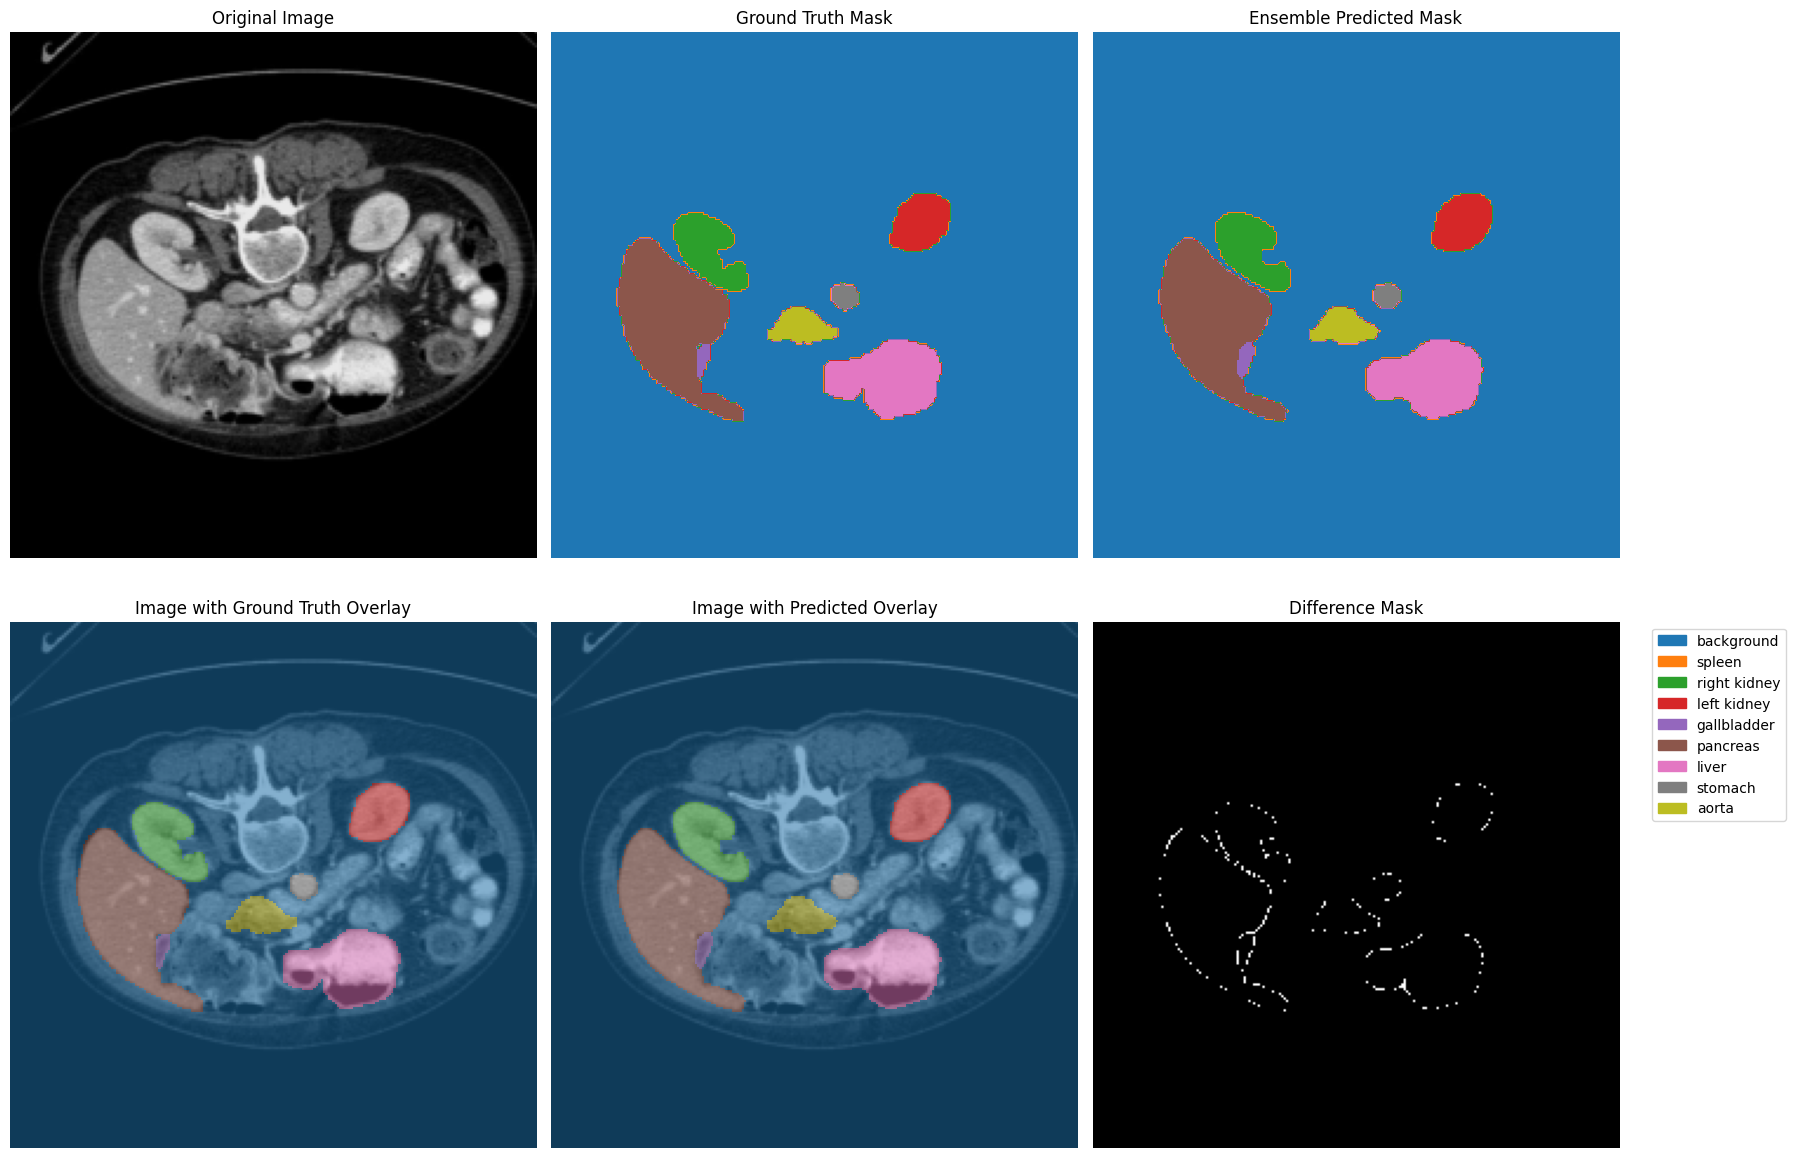

In [57]:
def visualize_ensemble_prediction(dataset, idx=None, filename=None, models=None, transform_image=None, method='softmax', device='cpu'):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import colors as mcolors
    from matplotlib import patches as mpatches
    from PIL import Image

    if models is None:
        raise ValueError("A list of trained models must be provided.")

    # Load image and mask
    if idx is not None:
        image, mask = dataset[idx]
        img_name = dataset.image_filenames[idx]
    elif filename is not None:
        idx = dataset.image_filenames.index(filename)
        image, mask = dataset[idx]
        img_name = filename
    else:
        raise ValueError("Either idx or filename must be provided.")

    # Prepare image for model input
    if transform_image:
        image_input = transform_image(Image.open(os.path.join(dataset.image_dir, img_name)).convert("RGB"))
    else:
        image_input = image

    # Add batch dimension and move to device
    image_input = image_input.unsqueeze(0).to(device)

    # Get ensemble prediction
    ensemble_pred = infer_ensemble(models, image_input, method=method)

    # Remove batch dimension and move to CPU
    ensemble_pred = ensemble_pred.squeeze(0).cpu().numpy()

    # Prepare image for visualization
    image_np = image.permute(1, 2, 0).numpy()
    image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)

    # Ground truth mask
    mask_np = mask.numpy()

    # Define class names and colors
    class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder',
                   'pancreas', 'liver', 'stomach', 'aorta']
    colors = plt.cm.tab10.colors  # Use tab10 colormap
    colormap = mcolors.ListedColormap(colors[:len(class_names)])

    # Create color masks
    mask_rgba = colormap(mask_np / (len(class_names) - 1))
    mask_rgba[..., 3] = 0.5  # Set alpha for transparency

    pred_mask_rgba = colormap(ensemble_pred / (len(class_names) - 1))
    pred_mask_rgba[..., 3] = 0.5  # Set alpha for transparency

    # Plotting
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    # Original Image
    axs[0, 0].imshow(image_np)
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')

    # Ground Truth Mask
    axs[0, 1].imshow(mask_np, cmap=colormap, vmin=0, vmax=len(class_names) - 1)
    axs[0, 1].set_title('Ground Truth Mask')
    axs[0, 1].axis('off')

    # Predicted Mask
    axs[0, 2].imshow(ensemble_pred, cmap=colormap, vmin=0, vmax=len(class_names) - 1)
    axs[0, 2].set_title('Ensemble Predicted Mask')
    axs[0, 2].axis('off')

    # Original Image with Ground Truth Mask Overlay
    axs[1, 0].imshow(image_np)
    axs[1, 0].imshow(mask_rgba, interpolation='none')
    axs[1, 0].set_title('Image with Ground Truth Overlay')
    axs[1, 0].axis('off')

    # Original Image with Predicted Mask Overlay
    axs[1, 1].imshow(image_np)
    axs[1, 1].imshow(pred_mask_rgba, interpolation='none')
    axs[1, 1].set_title('Image with Predicted Overlay')
    axs[1, 1].axis('off')

    # Difference between Ground Truth and Prediction
    diff_mask = (mask_np != ensemble_pred).astype(np.uint8)
    axs[1, 2].imshow(diff_mask, cmap='gray')
    axs[1, 2].set_title('Difference Mask')
    axs[1, 2].axis('off')

    # Create legend
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

visualize_ensemble_prediction(
    dataset=train_dataset,
    filename='train_0000.png',
    models=ensemble_models,
    transform_image=transform_image,
    method='softmax',
    device=device
)


/tmp/ipykernel_31/2464085244.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model3.load_state_dict(torch.load('/kaggle/input/unetplusplus50/pytorch/default/1/UNetPlus

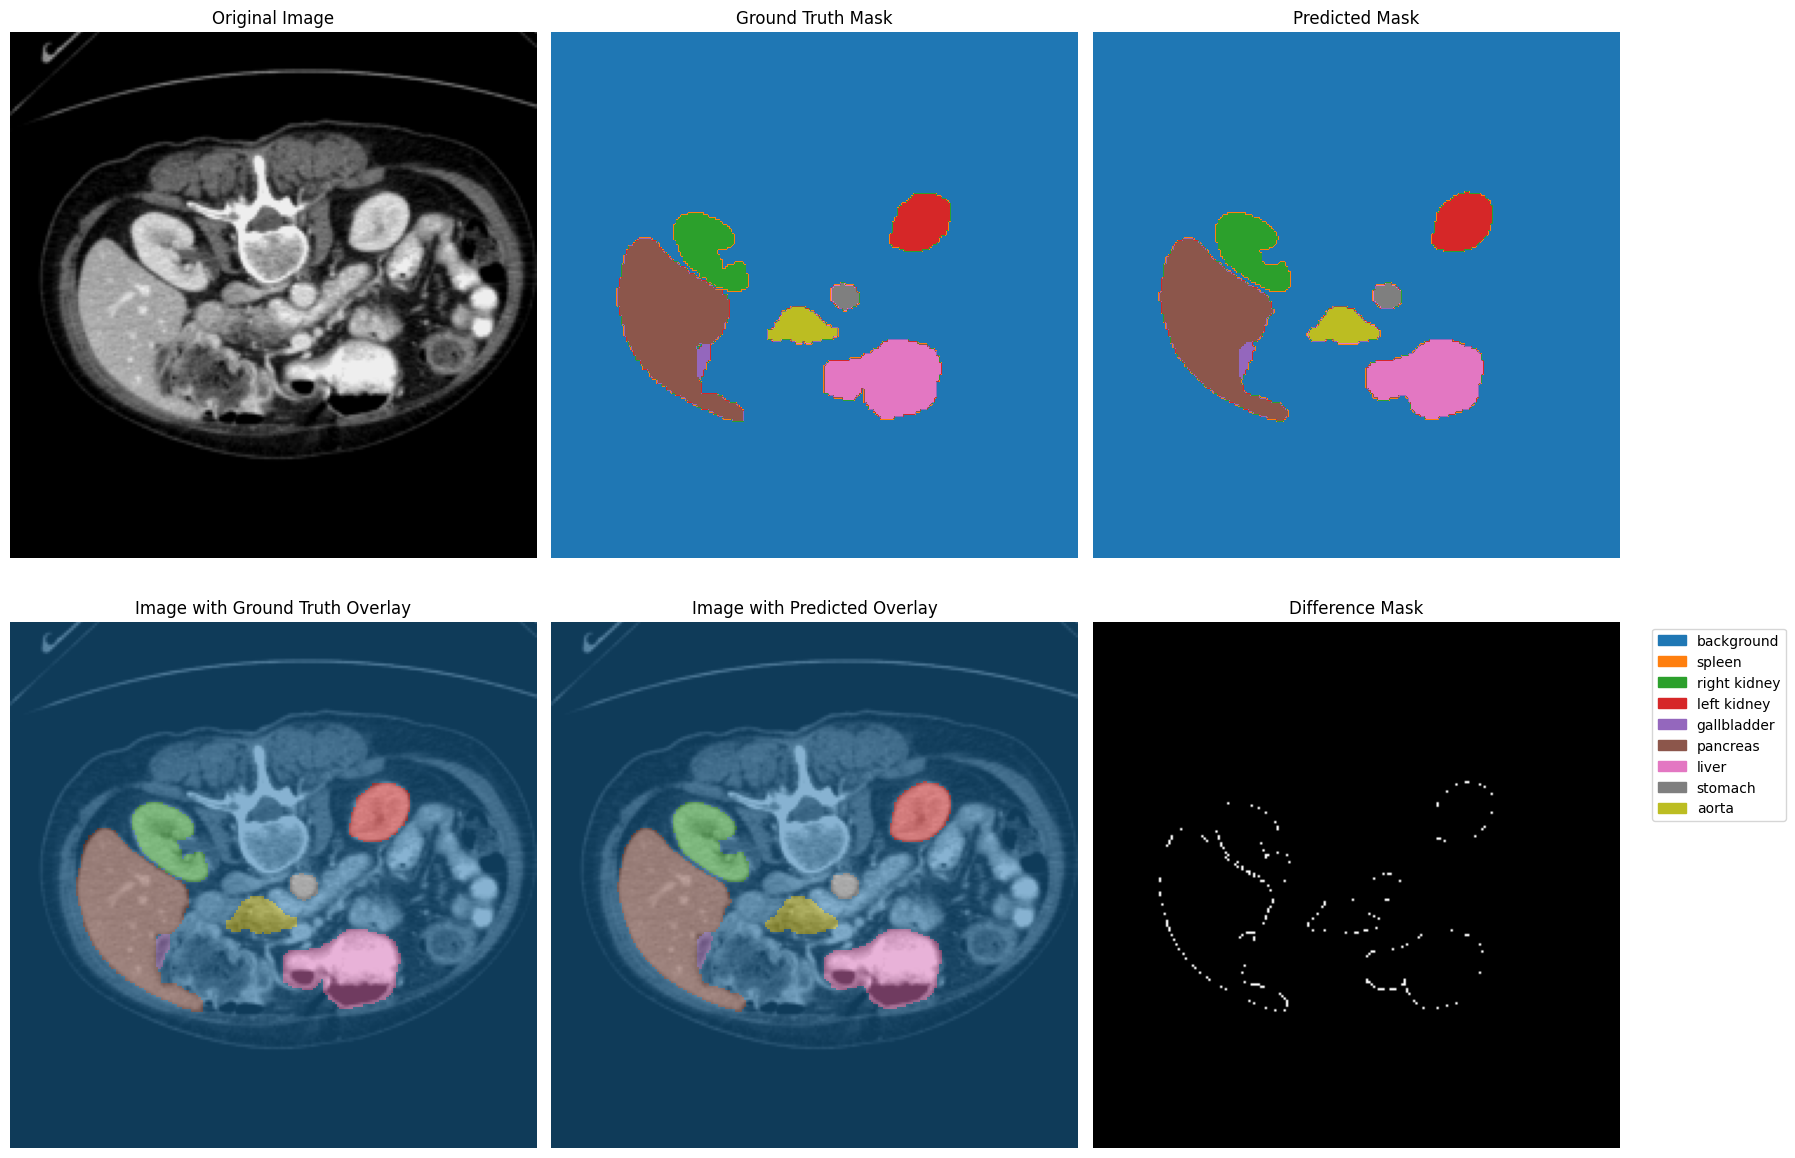

In [60]:
def visualize_prediction(dataset, idx=None, filename=None, model=None, transform_image=None, device='cpu'):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import colors as mcolors
    from matplotlib import patches as mpatches
    from PIL import Image
    import os

    if model is None:
        raise ValueError("A trained model must be provided.")

    # Load image and mask
    if idx is not None:
        image, mask = dataset[idx]
        img_name = dataset.image_filenames[idx]
    elif filename is not None:
        idx = dataset.image_filenames.index(filename)
        image, mask = dataset[idx]
        img_name = filename
    else:
        raise ValueError("Either idx or filename must be provided.")

    # Prepare image for model input
    if transform_image:
        # Load the original image from the file system
        image_path = os.path.join(dataset.image_dir, img_name)
        image_pil = Image.open(image_path).convert("RGB")
        image_input = transform_image(image_pil)
    else:
        image_input = image

    # Add batch dimension and move to device
    image_input = image_input.unsqueeze(0).to(device)

    # Get model prediction
    model.eval()
    with torch.no_grad():
        output = model(image_input)
        _, pred = torch.max(output, dim=1)

    # Remove batch dimension and move to CPU
    pred = pred.squeeze(0).cpu().numpy()

    # Prepare image for visualization
    image_np = image.permute(1, 2, 0).numpy()
    image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)

    # Ground truth mask
    mask_np = mask.numpy()

    # Define class names and colors
    class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder',
                   'pancreas', 'liver', 'stomach', 'aorta']
    colors = plt.cm.tab10.colors  # Use tab10 colormap
    colormap = mcolors.ListedColormap(colors[:len(class_names)])

    # Create color masks
    mask_rgba = colormap(mask_np / (len(class_names) - 1))
    mask_rgba[..., 3] = 0.5  # Set alpha for transparency

    pred_mask_rgba = colormap(pred / (len(class_names) - 1))
    pred_mask_rgba[..., 3] = 0.5  # Set alpha for transparency

    # Plotting
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    # Original Image
    axs[0, 0].imshow(image_np)
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')

    # Ground Truth Mask
    axs[0, 1].imshow(mask_np, cmap=colormap, vmin=0, vmax=len(class_names) - 1)
    axs[0, 1].set_title('Ground Truth Mask')
    axs[0, 1].axis('off')

    # Predicted Mask
    axs[0, 2].imshow(pred, cmap=colormap, vmin=0, vmax=len(class_names) - 1)
    axs[0, 2].set_title('Predicted Mask')
    axs[0, 2].axis('off')

    # Original Image with Ground Truth Mask Overlay
    axs[1, 0].imshow(image_np)
    axs[1, 0].imshow(mask_rgba, interpolation='none')
    axs[1, 0].set_title('Image with Ground Truth Overlay')
    axs[1, 0].axis('off')

    # Original Image with Predicted Mask Overlay
    axs[1, 1].imshow(image_np)
    axs[1, 1].imshow(pred_mask_rgba, interpolation='none')
    axs[1, 1].set_title('Image with Predicted Overlay')
    axs[1, 1].axis('off')

    # Difference between Ground Truth and Prediction
    diff_mask = (mask_np != pred).astype(np.uint8)
    axs[1, 2].imshow(diff_mask, cmap='gray')
    axs[1, 2].set_title('Difference Mask')
    axs[1, 2].axis('off')

    # Create legend
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Load model3
model3 = UNetPlusPlus50(in_channels=3, out_channels=9, dropout=0.5)  # Replace with your actual model class and parameters
model3.load_state_dict(torch.load('/kaggle/input/unetplusplus50/pytorch/default/1/UNetPlusPlus_model3.pth'))
model3 = model3.to(device)
model3.eval()

# Visualize the prediction
visualize_prediction(
    dataset=train_dataset,
    filename='train_0000.png',
    model=model3,
    transform_image=transform_image,
    device=device
)
